In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
from RTKToArrayConversion import *
from ExtendedConeBeamDCC import *
from TextFileSaving import * 
from ConeBeamDCCWithBackprojectionPlane import *
from AllAcquisitionCD_Beta_Class import *
%matplotlib notebook
plt.rcParams.update({'font.size': 14})

def moving_average(x, y, w):
    ma = np.zeros(x.shape)
    weights = np.zeros(x.shape)
    for i in range(x.shape[0]):
#         print(len(np.where(np.abs(x-x[i]) <= w//2)[0]))
        ma[i] += np.mean(y[np.where(np.abs(x-x[i]) <= w//2)])
#         weights[i] += len(np.where(np.abs(x-x[i]) <= w//2)[0])
    return ma

In [3]:
# filesdir_ref = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/"

# xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
# xmlreader.SetFilename(filesdir_ref+'geometry.xml')
# xmlreader.GenerateOutputInformation()
# geometry_tot = xmlreader.GetOutputObject()
# geometry_tot_ar = RTKtoNP(geometry_tot)

# xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
# xmlreader.SetFilename(filesdir_ref+'n115_n30/geometry_n30_n115.xml')
# xmlreader.GenerateOutputInformation()
# geometry_sub = xmlreader.GetOutputObject()
# geometry_sub_ar = RTKtoNP(geometry_sub)

# current = np.genfromtxt(filesdir_ref + "tube_current_sans_comp.txt", skip_header=0, unpack=True, delimiter= ',').T

# print(geometry_tot_ar.shape, current.shape)

# idx= np.where(geometry_sub_ar[8, 0] == geometry_tot_ar[8,:])[0]
# idx_f = idx[np.where(geometry_sub_ar[2, 0] == geometry_tot_ar[2,idx])][0]
# print(idx,idx_f)
# print(geometry_sub_ar[:, 0])
# print(geometry_tot_ar[:, idx_f])

# current_sub = current[idx_f:idx_f+geometry_sub_ar.shape[1]]
# print(len(current_sub), geometry_sub_ar.shape[1])

# np.savetxt(filesdir_ref + "n115_n30/sans_comp_tube_current_n30_n115.txt", current_sub, delimiter=',')

In [4]:
filesdir_ref = "/home/mmouchet/Documents/Report/thesis/simu/test/"
# reading projections
proj = itk.imread(filesdir_ref+"projections_motion_9200x01028_noise.mha")
# Reading the geometry of the scanner
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(filesdir_ref+'geometry_9200x01028.xml')
# xmlreader.SetFilename(filesdir_ref+"geometry.xml")
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()
print('nproj = %d'%(len(geometry.GetGantryAngles())))
print(proj.GetLargestPossibleRegion().GetSize())

# bt_120 = np.genfromtxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/doc/bowtie/BowTieProfilesFiles/Wedge_120_w1.txt', skip_header=1, unpack=True).T
# supp_current = np.genfromtxt(filesdir_ref + "sans_comp_tube_current_n42_42.txt", skip_header=0, unpack=True, delimiter= ',').T

nproj = 1440
itkSize3 ([9200, 32, 1440])


In [5]:
# # # shrinkage
# # ImageType = itk.Image[itk.F,3]
# # rebin = itk.BinShrinkImageFilter[ImageType,ImageType].New()
# # rebin.SetInput(proj)
# # rebin.SetShrinkFactor(0,10)
# # rebin.Update()
# # proj_rebin = rebin.GetOutput()
# # itk.imwrite(proj_rebin,filesdir_ref + 'projections_thorax_4x360_920x1028_shrink10_a160.mha')
# # print(proj_rebin.GetSpacing())
# restot0 = []
# restot1 = []
# for it in tqdm_notebook(range(100)):
#     I0=10**5
#     dH2O=0.01879 #mm^-1 at 75 keV
#     if I0!=0:
#         new_sino = I0*np.exp(-1.*dH2O*itk.GetArrayFromImage(proj))
#         new_sino = np.maximum(np.random.poisson(new_sino), 1)
#         new_sino = np.log(I0/new_sino)/dH2O
#         proj_rebin_n = itk.GetImageFromArray(new_sino.astype(np.float32)) 
#         proj_rebin_n.CopyInformation(proj)
#         proj_rebin_n.Update()
#     geometry_array = RTKtoNP(geometry)
#     proj_array = itk.GetArrayFromImage(proj_rebin_n)
#     proj_infos = GetProjectionInformations(proj_rebin_n)
#     source_pos_array = GetSourcePositions(geometry)
#     rotation_matrices_array = GetRotationMatrices(geometry)
#     fixed_matrices_array = GetFixedSystemMatrices(geometry)
#     AcquiDCC = DCCOnCDinAnAcquisition(geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos)
#     ref = 720
#     N = AcquiDCC.axial_limit
#     res0 = []
#     res1 = []
#     idx = []
#     for i in range(-2*N,2*N):
#         if ref == i+ref or i+ref <0 or i+ref >= proj_infos[2][2] or np.abs(geometry_array[2, ref]-geometry_array[2, ref+i]) <10**(-12) :
#             pass
#         else:
#             pair = ProjectionsPair(ref, i+ref , AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, AcquiDCC.Ni)
#             pair.ComputeMPoints()
#             pair.ComputeEpipolarPlanes()
#             if len(np.where(pair.final_cond)[0]) >= 1:
#                 pair.ComputePairMoments()
#                 idx.append(i+ref)
#                 if type(pair.m0) == np.float64:
#                     res0.append(np.mean(np.array([pair.m0])))
#                     res1.append(np.mean(np.array([pair.m1])))
#                 else: 
#                     res0.append(np.mean(pair.m0))
#                     res1.append(np.mean(pair.m1))
#     restot0.append(res0)
#     restot1.append(res1)

# #     itk.imwrite(proj_rebin_n,filesdir_ref + 'projections_thorax_4x360_920x1028_shrink10_a160_noise.mha') 

# restot0ar = np.array(restot0)
# restot1ar = np.array(restot1)
# print(restot0ar.shape)
# std0 = np.var(restot0ar, axis = 0)
# std1 = np.var(restot1ar, axis = 0)
# print(std0.shape)

# # plt.figure()
# # plt.plot(idx, std0)
# # plt.plot(idx, [np.sqrt(res[i][4]/len(res[i][0])**2) for i in range(len(res))])
# # plt.show()

# # plt.figure()
# # plt.plot(idx, std1)
# # plt.plot(idx, [np.sqrt(res[i][5]/len(res[i][1])**2) for i in range(len(res))])
# # plt.show()

In [6]:
#Convert to array for faster computation
geometry_array = RTKtoNP(geometry)
proj_array = itk.GetArrayFromImage(proj)
proj_infos = GetProjectionInformations(proj)
source_pos_array = GetSourcePositions(geometry)
rotation_matrices_array = GetRotationMatrices(geometry)
fixed_matrices_array = GetFixedSystemMatrices(geometry)
print(proj_infos)
AcquiDCC = DCCOnCDinAnAcquisition(geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos)
# AcquiDCC.ComputeInitialNumberOfPhotons(bt_120, supp_current)

[array([0.1028, 1.095 , 1.    ]), array([-472.8286,  -16.9725,    0.    ]), array([9200,   32, 1440]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])]


In [7]:
AcquiDCC.n_proj_per_rotation

360

In [8]:
# print(AcquiDCC.axial_limit)
# z_dcc = (geometry_array[8, 0]+ geometry_array[8, -1])*0.5
# print(z_dcc)
# first_idx = np.where(geometry_array[8,:]<=z_dcc)[0][0]
# last_idx = np.where(geometry_array[8,:]>=z_dcc)[0][-1]
# print(first_idx, last_idx)
# print(geometry_array[8,first_idx],geometry_array[8,last_idx] )

In [14]:
print(proj_array.shape)

(1440, 32, 9200)


In [43]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
import time

ref = 720
print(geometry_array[8,0],geometry_array[8, ref])
N = AcquiDCC.axial_limit
print(N)
# N = 420

# res = []
# idx = []
res2 = []
idx2 = []
for i in tqdm_notebook(range(-N,N)):
    if ref == i+ref or i+ref <0 or i+ref >= proj_infos[2][2] or np.abs(geometry_array[2, ref]-geometry_array[2, ref+i]) <10**(-12) :
        pass
#     elif np.cos(AcquiDCC.geometry[2, ref]-AcquiDCC.geometry[2, i+ref]) > 2*((AcquiDCC.R_fov)/AcquiDCC.geometry[0, 0])**2-1:
    else:
#         pair = ProjectionsPairMpoints(ref, i+ref , AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, AcquiDCC.Ni, AcquiDCC.spiral_dir)
#         pair.ComputeMPoints()
#         pair.ComputeEpipolarPlanes()
#         if len(np.where(pair.final_cond)[0]) >= 1:
#             pair.ComputePairMoments()
#             idx.append(i+ref)
#             if type(pair.mhr0) == np.float64:
#                 res.append([np.array([pair.mhr0]), np.array([pair.mhr1]), np.array([pair.mhh0]), np.array([pair.mhh1]), np.array([pair.mk0]), np.array([pair.mk1])])
#             else: 
#                 res.append([pair.mhr0, pair.mhr1, pair.mhh0, pair.mhh1, pair.mk0, pair.mk1])
                
        pairb = ProjectionsPairBeta(ref, i+ref, AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, AcquiDCC.Ni, 'True', 'Hann', 5)
        pairb.ComputeBetaRange()
        if len(pairb.beta) >= 1:
            pairb.ComputePairMoments()
            idx2.append(i+ref)
            if type(pairb.m0) == np.float64:
                res2.append([np.array([pairb.m0]), np.array([pairb.m1]), pairb.var0, pairb.var1, np.array([pairb.tot_var0]), np.array([pairb.tot_var1])])
            else: 
                res2.append([pairb.m0, pairb.m1, pairb.var0, pairb.var1, pairb.tot_var0, pairb.tot_var1])
                
# savedir = "/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/statistics/FOV2/"
# WriteMomentsFile(filesdir_ref+"test", idx, res)

-30.72 0.0
720


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [44]:
savedir = "/home/mmouchet/Documents/Report/thesis/simu/test/"
WriteMomentsFile(savedir+"motion_9200x01028_noise_hannWover5", idx2, res2)

0

<IPython.core.display.Javascript object>


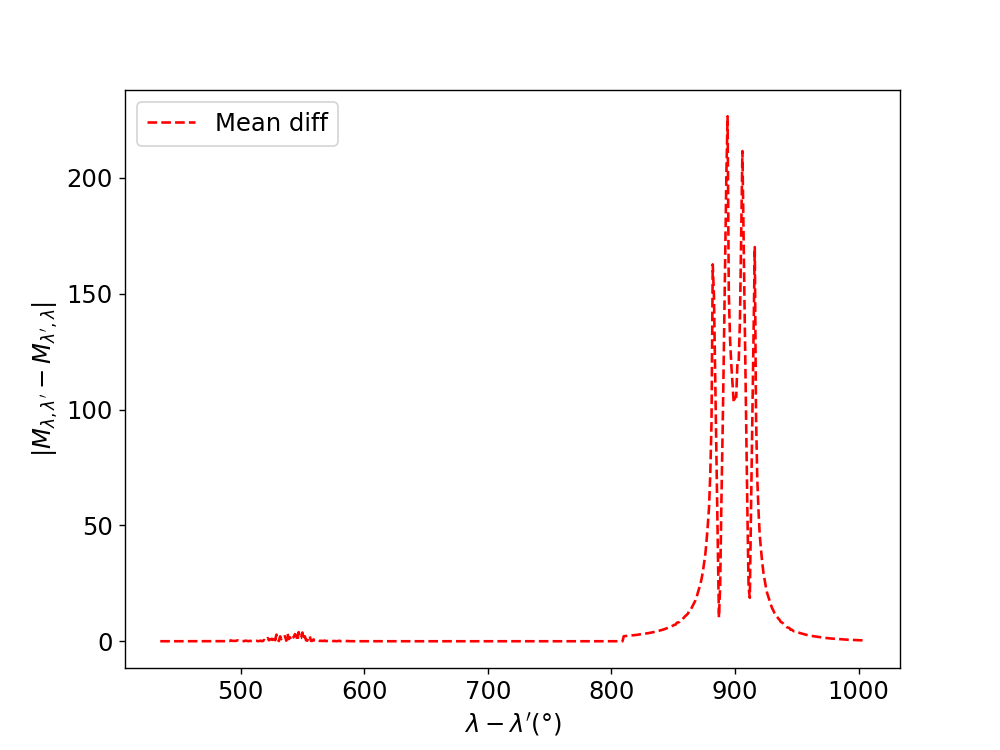

In [45]:
plt.figure(figsize = (8,6))
# plt.plot(np.array(idx),[np.mean(np.abs(res[i][0]-res[i][1])) for i in range(len(res))], 'k', label="Mean diff")
plt.plot(np.array(idx2),[np.mean(np.abs(res2[i][0]-res2[i][1])) for i in range(len(res2))], 'r--', label="Mean diff")
# plt.plot(np.array(idx2),[np.abs(np.mean(res2[i][2])-np.mean(res2[i][3])) for i in range(len(res2))], label="Mean diff")
# plt.plot(np.array(idx2),[np.abs(np.mean(res2[i][4])-np.mean(res2[i][5])) for i in range(len(res2))], label="Mean diff")
# plt.plot(np.array(idx),[np.sqrt(res[i][4]+res[i][5]) for i in range(len(res))], label="Mean diff")
plt.xlabel(r"$\lambda-\lambda'$(°)")
plt.ylabel(r"$\left| M_{\lambda,\lambda'} - M_{\lambda',\lambda}\right|$")
plt.legend()
plt.show()


# plt.figure(figsize = (8,6))
# plt.plot(np.array(idx)-720, var01_it50)
# plt.plot(np.array(idx)-720, [res[i][6]/len(res[i][0])**2+res[i][7]/len(res[i][1])**2 for i in range(len(res))], label="Mean diff")
# plt.xlabel(r"$\lambda-\lambda'$(°)")
# plt.ylabel(r"$\left| M_{\lambda,\lambda'} - M_{\lambda',\lambda}\right|$")
# plt.legend()
# plt.show()

In [ ]:
directory = "/home/mmouchet/Documents/Report/thesis/simu/chapter05/bash_files/"
np.savetxt(directory + "indexes.txt", np.array(idx))
np.savetxt(directory + "diff_mean_moments_noisy.txt", np.array([np.mean(res[i][0])-np.mean(res[i][1]) for i in range(len(res))]))
np.savetxt(directory + "diff_abs_mean_moments_noisy.txt", np.array([np.mean(np.abs(res[i][0]-res[i][1])) for i in range(len(res))]))
np.savetxt(directory + "variance_th_m0_m1.txt", np.array([res[i][4]+res[i][5] for i in range(len(res))]))
np.savetxt(directory + "variance_th_0.txt", np.array([res[i][4] for i in range(len(res))]))
np.savetxt(directory + "variance_th_1.txt", np.array([res[i][5] for i in range(len(res))]))
# np.savetxt(directory + "variance_th_central_0.txt", np.array([res[i][4][len(res[i][4])//2] for i in range(len(res))]))
# np.savetxt(directory + "variance_th_central_1.txt", np.array([res[i][5][len(res[i][5])//2] for i in range(len(res))]))

In [ ]:
var0_it50 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it50_0.txt")
var0_it100 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it100_0.txt")
var0_it200 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it200_0.txt")
var0_it1000 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it1000_0.txt")
var0_it10000 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it10000_0.txt")
var1_it50 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it50_1.txt")
var1_it100 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it100_1.txt")
var1_it200 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it200_1.txt")
var1_it1000 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it1000_1.txt")
var1_it10000 = np.genfromtxt("/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/test_variance2/variance_it10000_1.txt")

# var0_th = [res[i][2][len(res[i][2])//2] for i in range(len(res))]
# var1_th = [res[i][3][len(res[i][3])//2] for i in range(len(res))]
var0_th = [res[i][4] for i in range(len(res))]
var1_th = [res[i][5] for i in range(len(res))]

er0 = np.zeros(5)
er0[0] += 100*np.sum(np.abs(var0_it50-var0_th)/var0_th)/len(var0_th)
er0[1] += 100*np.sum(np.abs(var0_it100-var0_th)/var0_th)/len(var0_th)
er0[2] += 100*np.sum(np.abs(var0_it200-var0_th)/var0_th)/len(var0_th)
er0[3] += 100*np.sum(np.abs(var0_it1000-var0_th)/var0_th)/len(var0_th)
er0[4] += 100*np.sum(np.abs(var0_it10000-var0_th)/var0_th)/len(var0_th)

er1 = np.zeros(5)
er1[0] += 100*np.sum(np.abs(var1_it50-var1_th)/var1_th)/len(var1_th)
er1[1] += 100*np.sum(np.abs(var1_it100-var1_th)/var1_th)/len(var1_th)
er1[2] += 100*np.sum(np.abs(var1_it200-var1_th)/var1_th)/len(var1_th)
er1[3] += 100*np.sum(np.abs(var1_it1000-var1_th)/var1_th)/len(var1_th)
er1[4] += 100*np.sum(np.abs(var1_it10000-var1_th)/var1_th)/len(var1_th)

plt.figure(figsize = (8,6))
plt.plot(np.array([50, 100, 200, 1000, 10000]), er0, label=r"$Var\left(M_{\lambda,\lambda'}\right)$")
plt.plot(np.array([50, 100, 200, 1000, 10000]), er1, label=r"$Var\left(M_{\lambda',\lambda}\right)$")
plt.xlabel("Number of realizations")
plt.xscale("log")
plt.ylabel("Mean relative error (%)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(np.array(idx)-720, var0_th, label="theory")
plt.plot(np.array(idx)-720, var0_it10000, '--', label="10000 realizations")
plt.xlabel(r"$\lambda-\lambda'$(°)")
plt.ylabel(r"$Var\left(M_{\lambda,\lambda'}\right)$")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(np.array(idx)-720, var1_th, label="theory")
plt.plot(np.array(idx)-720, var1_it10000, '--', label="10000 realizations")
plt.xlabel(r"$\lambda-\lambda'$(°)")
plt.ylabel(r"$Var\left((M_{\lambda',\lambda}\right)$")
plt.legend()
plt.show()

In [ ]:
%matplotlib notebook
I0_var_a = []
I0_th_a = []
m_tot_a = []
mean_proj_a = []

I0_var_b = []
I0_th_b = []
m_tot_b = []
mean_proj_b = []

I0_var_c = []
I0_th_c = []
m_tot_c = []
mean_proj_c = []
proj_id = np.array(np.where(np.abs(geometry_array[2,:]-4.829347824926022)<np.abs(geometry_array[2,  1]-geometry_array[2,  0]))[0])

print(geometry_array[2,proj_id])
plt.figure()
plt.imshow(proj_array[proj_id[0], :, :], extent=(AcquiDCC.gamma[0]*180/np.pi, AcquiDCC.gamma[-1]*180/np.pi, 0, 31))
plt.axvline(AcquiDCC.gamma[45]*180/np.pi, color = 'green')
plt.axvline(AcquiDCC.gamma[90]*180/np.pi, color='red')
plt.axvline(AcquiDCC.gamma[135]*180/np.pi, color = 'yellow')
plt.axvline(AcquiDCC.gamma[180]*180/np.pi)
plt.show()

# bt_120 = np.genfromtxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/doc/bowtie/BowTieProfilesFiles/Wedge_120_w1.txt', skip_header=1, unpack=True).T
# bt_factor = np.interp(np.array([AcquiDCC.gamma[45],AcquiDCC.gamma[90],AcquiDCC.gamma[135]]), bt_120[:, 0]*np.pi/180, bt_120[:, 1])
# supp_current = np.genfromtxt("/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/tube_current_sans_comp.txt", skip_header=0, unpack=True, delimiter= ',').T
# supp_int = np.array([bt_factor]*len(proj_id)).T*(0.001*supp_current[19*12593+proj_id]*120000**2)

# proj_set = np.array([proj_array[proj_id, :, 45],proj_array[proj_id, :, 90], proj_array[proj_id, :, 135]])
# m = (2294.5**2/np.var(proj_set, axis = 2))/supp_int

# print(supp_int.shape, np.mean(proj_set, axis = (2)).shape, m.shape)

# I0_var_a.append(2294.5**2/np.var(proj_set, axis = 2)[0,:])
# I0_th_a.append(supp_int[0,:])
# m_tot_a.append(m[0,:])
# mean_proj_a.append(np.mean(proj_set, axis = (2))[0,:])
# I0_var_b.append(2294.5**2/np.var(proj_set, axis = 2)[1,:])
# I0_th_b.append(supp_int[1,:])
# m_tot_b.append(m[1,:])
# mean_proj_b.append(np.mean(proj_set, axis = (2))[1,:])
# I0_var_c.append(2294.5**2/np.var(proj_set, axis = 2)[2,:])
# I0_th_c.append(supp_int[2,:])
# m_tot_c.append(m[2,:])
# mean_proj_c.append(np.mean(proj_set, axis = (2))[2,:])

# # plt.figure()
# # plt.subplot(411)
# # plt.plot(np.mean(proj_set, axis = (2)).T)
# # plt.xticks([])
# # plt.subplot(412)
# # plt.plot(2294.5**2/np.var(proj_set, axis = 2).T)
# # plt.xticks([])
# # plt.subplot(413)
# # plt.plot(supp_int.T)
# # plt.xticks([])
# # plt.subplot(414)
# # plt.plot(m.T)
# # plt.axhline(y=np.mean(m), color='k')
# # plt.show()

# # print(np.mean(m, axis = 1))

# print(len(m_tot_a),len(m_tot_b), len(m_tot_c))

# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/m_tot_sans_comp_channel45.txt', np.concatenate(m_tot_a), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/I0_var_sans_comp_channel45.txt', np.concatenate(I0_var_a), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/I0_th_sans_comp_channel45.txt', np.concatenate(I0_th_a), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/mean_proj_sans_comp_channel45.txt', np.concatenate(mean_proj_a), delimiter=',')

# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/m_tot_sans_comp_channel90.txt', np.concatenate(m_tot_b), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/I0_var_sans_comp_channel90.txt', np.concatenate(I0_var_b), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/I0_th_sans_comp_channel90.txt', np.concatenate(I0_th_b), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/mean_proj_sans_comp_channel90.txt', np.concatenate(mean_proj_b), delimiter=',')

# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/m_tot_sans_comp_channel135.txt', np.concatenate(m_tot_c), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/I0_var_sans_comp_channel135.txt', np.concatenate(I0_var_c), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/I0_th_sans_comp_channel135.txt', np.concatenate(I0_th_c), delimiter=',')
# np.savetxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/4D_patients/MP/donneesBrutes/sans_comp/mean_proj_sans_comp_channel135.txt', np.concatenate(mean_proj_c), delimiter=',')
